In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import pickle
import cv2
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout



In [2]:
baseDir=os.getcwd()
dataDir=os.path.join(baseDir, 'data')
training_file=os.path.join(dataDir,'train.p')
testing_file=os.path.join(dataDir,'test.p')

In [3]:
with open(training_file,'rb') as f:
    train = pickle.load(f)
    
with open(testing_file,'rb') as f:
    test = pickle.load(f)

In [4]:
train.keys()

dict_keys(['sizes', 'coords', 'features', 'labels'])

In [5]:
test.keys()

dict_keys(['sizes', 'coords', 'features', 'labels'])

In [6]:
train['labels']

array([ 0,  0,  0, ..., 42, 42, 42], dtype=uint8)

In [7]:
X_train,y_train=train['features'],train['labels']
X_test,y_test=test['features'],test['labels']

In [8]:
X_train[0].shape

(32, 32, 3)

In [9]:
print('Image Shape:    {}'.format(X_train[0].shape))
print('Training Set:   {} samples'.format(len(X_train)))
print('Test Set:       {} samples'.format(len(X_test)))
##print('Labels in Set:  {}'.format(np.unique(y_train)))
print('Number of unique classes: {}'.format(len(np.unique(y_train))))

Image Shape:    (32, 32, 3)
Training Set:   39209 samples
Test Set:       12630 samples
Number of unique classes: 43


In [10]:
signnames=pd.read_csv('signnames.csv')

In [11]:
from sklearn.utils import shuffle
X_train, y_train=shuffle(X_train, y_train)

In [12]:
from sklearn.model_selection import train_test_split
test_features, valid_features, test_labels, valid_labels= train_test_split(X_test,y_test, test_size=0.60, random_state=42)

In [13]:
print('Number of validation examples = {}'.format(len(valid_labels)))
print('Number of testing examples = {}'.format(len(test_labels)))

Number of validation examples = 7578
Number of testing examples = 5052


In [14]:
print("X_train.shape: {}".format(X_train.shape))
print("valid_features.shape: {}".format(valid_features.shape))
print("y_train.shape: {}".format(y_train.shape))
print("valid_labels.shape: {}".format(valid_labels.shape))

X_train.shape: (39209, 32, 32, 3)
valid_features.shape: (7578, 32, 32, 3)
y_train.shape: (39209,)
valid_labels.shape: (7578,)


### One hot encoding the labels

In [15]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 43)
valid_labels = to_categorical(valid_labels, 43)

In [16]:
print(y_train.shape)
print(valid_labels.shape)

(39209, 43)
(7578, 43)


In [17]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
# We have 43 classes that's why we have defined 43 in the dense
model.add(Dense(43, activation='softmax'))

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(valid_features, valid_labels))

Epoch 1/20
1226/1226 [==============================] - 69s 55ms/step - loss: 1.6161 - accuracy: 0.5847 - val_loss: 0.5647 - val_accuracy: 0.8333
Epoch 2/20
1226/1226 [==============================] - 85s 70ms/step - loss: 0.6910 - accuracy: 0.7926 - val_loss: 0.4042 - val_accuracy: 0.8815
Epoch 3/20
1226/1226 [==============================] - 84s 68ms/step - loss: 0.5423 - accuracy: 0.8351 - val_loss: 0.3736 - val_accuracy: 0.9001
Epoch 4/20
1226/1226 [==============================] - 84s 69ms/step - loss: 0.4767 - accuracy: 0.8561 - val_loss: 0.3751 - val_accuracy: 0.9017
Epoch 5/20
1226/1226 [==============================] - 86s 70ms/step - loss: 0.4329 - accuracy: 0.8677 - val_loss: 0.2922 - val_accuracy: 0.9203
Epoch 6/20
1226/1226 [==============================] - 88s 72ms/step - loss: 0.4001 - accuracy: 0.8786 - val_loss: 0.3336 - val_accuracy: 0.9091
Epoch 7/20
1226/1226 [==============================] - 88s 71ms/step - loss: 0.3792 - accuracy: 0.8849 - val_loss: 0.3133 -

### Loss Curve

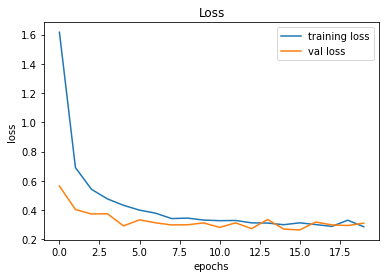

In [23]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Accuracy Curve

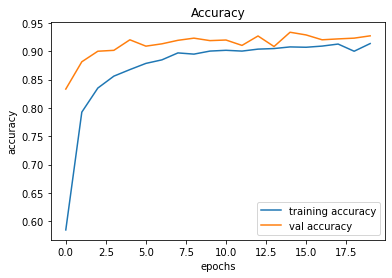

In [38]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### Accuracy with the test data

In [39]:
y_pred = np.argmax(model.predict(X_test),axis=1)
y_pred

395/395 [==============================] - 6s 15ms/step


array([16,  1, 38, ...,  3,  7, 10], dtype=int64)

In [40]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.9242280285035629


In [56]:
import pickle
from keras.models import load_model
model.save('classifier')

INFO:tensorflow:Assets written to: classifier\assets


INFO:tensorflow:Assets written to: classifier\assets


In [61]:
with open('classifier.pkl', 'wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://de35cbef-3df4-4419-bbfa-39e1ad2da531/assets


INFO:tensorflow:Assets written to: ram://de35cbef-3df4-4419-bbfa-39e1ad2da531/assets
